**STYLE TRANSFERING**

In [ ]:
import os
import tensorflow as tf

os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
    tensor = tensor * 255

    tensor = np.array(tensor, dtype=np.uint8)

    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]

    return PIL.Image.fromarray(tensor)


DOWNLOAD CONTENT AND STYLE TO APPLY

In [ ]:
content_path = tf.keras.utils.get_file(
    'koshka.jpg',
    'https://www.ferra.ru/imgs/2024/05/08/05/6460496/c2150453d059e8999c5f0b211ce334f7c869147c.jpg'
)

style_path = tf.keras.utils.get_file(
    'VanGogh.jpg',
    'https://cdn.culture.ru/images/88a3d26f-9ac8-56cf-a42a-923148f0f31c'
)


644891/644891 ━━━━━━━━━━━━━━━━━━━━ 1s 1us/step


In [ ]:
def load_img(path_to_img):
    max_dim = 512

    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)

    img = img[tf.newaxis, :]
    return img


In [ ]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)
    plt.imshow(image)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()


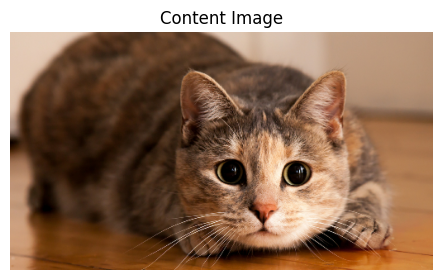

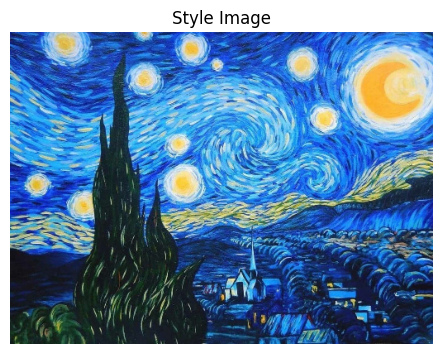

In [ ]:
content_image = load_img(content_path)

style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

plt.show()


**Output of existing NST**

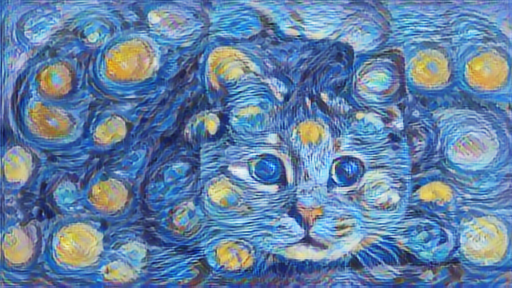

In [ ]:
import tensorflow_hub as hub

hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]

result_image = tensor_to_image(stylized_image)

result_image

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image * 255)
x = tf.image.resize(x, (224, 224))

vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')

prediction_probabilities = vgg(x)
prediction_probabilities.shape


574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


TensorShape([1, 1000])

In [ ]:
predicted_top_5 = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]

[(class_name, prob) for (number, class_name, prob) in predicted_top_5]

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[('Egyptian_cat', 0.30425224),
 ('carton', 0.19421846),
 ('tabby', 0.1312248),
 ('tiger_cat', 0.059302974),
 ('bucket', 0.027365653)]

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print("Layer names in VGG19:")
for layer in vgg.layers:
    print(layer.name)


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Layer names in VGG19:
input_layer_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_layers = ['block5_conv2']

style_layers = [
    'block1_conv1',
    'block2_conv1',
    'block3_conv1',
    'block4_conv1',
    'block5_conv1'
]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
print(num_content_layers, num_style_layers)

1 5


In [ ]:
def vgg_layers(layer_names):
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False

    outputs = [vgg.get_layer(name).output for name in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model


In [ ]:
style_extractor = vgg_layers(style_layers)

style_outputs = style_extractor(style_image * 255)

for name, output in zip(style_layers, style_outputs):
    print(name)
    print("  shape: ", output.numpy().shape)
    print("  min: ", output.numpy().min())
    print("  max: ", output.numpy().max())
    print("  mean: ", output.numpy().mean())
    print()


block1_conv1
  shape:  (1, 378, 512, 64)
  min:  0.0
  max:  810.6813
  mean:  32.12606

block2_conv1
  shape:  (1, 189, 256, 128)
  min:  0.0
  max:  3880.277
  mean:  186.10138

block3_conv1
  shape:  (1, 94, 128, 256)
  min:  0.0
  max:  8372.87
  mean:  200.17073

block4_conv1
  shape:  (1, 47, 64, 512)
  min:  0.0
  max:  20297.955
  mean:  742.24316

block5_conv1
  shape:  (1, 23, 32, 512)
  min:  0.0
  max:  4982.1543
  mean:  65.68137



In [ ]:
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)

    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
    return result / num_locations


In [ ]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)

        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                           outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output) for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}


In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(results['style'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())
    print()


print("Contents:")
for name, output in sorted(results['content'].items()):
    print("  ", name)
    print("    shape: ", output.numpy().shape)
    print("    min: ", output.numpy().min())
    print("    max: ", output.numpy().max())
    print("    mean: ", output.numpy().mean())


Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.0
    max:  16860.295
    mean:  347.20227

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  48607.453
    mean:  10355.307

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  245647.97
    mean:  10002.295

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  3223913.2
    mean:  184581.16

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  192495.42
    mean:  1820.8839

Contents:
   block5_conv2
    shape:  (1, 18, 32, 512)
    min:  0.0
    max:  2099.4385
    mean:  17.2907


In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']


In [ ]:
image = tf.Variable(content_image)


In [ ]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)


In [ ]:
style_weight = 1e-2
content_weight = 1e4


In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([
        tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
        for name in style_outputs.keys()
    ])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([
        tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
        for name in content_outputs.keys()
    ])
    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss


TEST

Image update using Gradient descend

In [ ]:
@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))


In [ ]:
train_step(image)
train_step(image)
train_step(image)

result_image = tensor_to_image(image)
result_image.show()


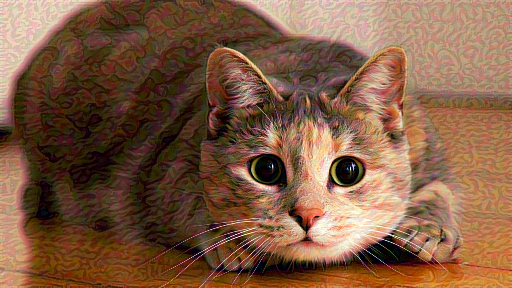

In [ ]:
result_image

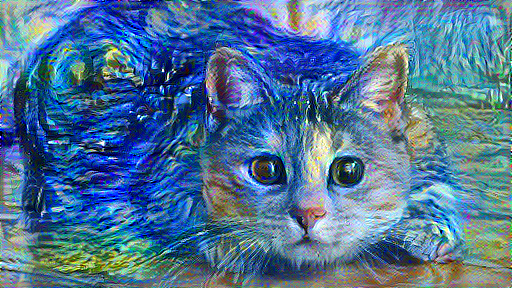

Train step: 1000
Total time: 5980.2


In [ ]:
import time

start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)

    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end - start))


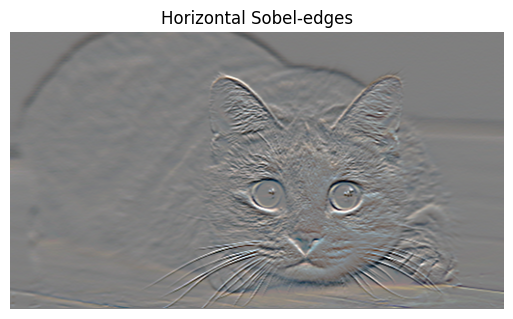

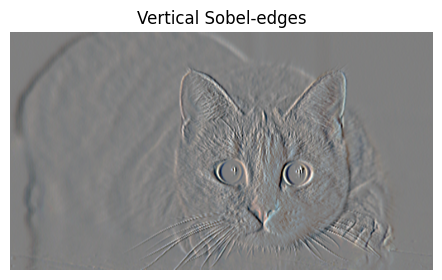

<Figure size 1200x1200 with 0 Axes>

In [ ]:
plt.figure(figsize=(14, 10))

sobel = tf.image.sobel_edges(content_image)
plt.subplot(1, 2, 1)
imshow(clip_0_1(sobel[..., 0] / 4 + 0.5), "Horizontal Sobel-edges")

plt.subplot(1, 2, 2)
imshow(clip_0_1(sobel[..., 1] / 4 + 0.5), "Vertical Sobel-edges")

plt.tight_layout()
plt.show()


In [ ]:
tv_loss_tf = tf.image.total_variation(image).numpy()
print("Total Variation Loss (TensorFlow):", tv_loss_tf)


Total Variation Loss (TensorFlow): [99295.39]


**Reload optimization**

In [ ]:
total_variation_weight = 30

@tf.function()
def train_step(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs)

        loss += total_variation_weight * tf.image.total_variation(image)

    grad = tape.gradient(loss, image)

    opt.apply_gradients([(grad, image)])

    image.assign(clip_0_1(image))


In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

image = tf.Variable(content_image)


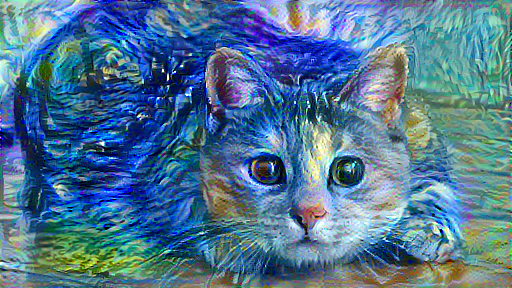

Train step: 600
.

In [ ]:
import time

start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
    for m in range(steps_per_epoch):
        step += 1
        train_step(image)
        print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))
